In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# <b><span style='color:#4797ef'>|</span> EDA | III Investigate data before modelling</b>

In [2]:
df = pd.read_csv("../data/df_for_modelling.csv", index_col=0)
df.sort_values(by=["year", "month", "day"], ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()
df.head()

,FeelsLikeC,maxtempC,mintempC,windspeedKmph,cloudcover,humidity,pressure,visibility,is_holiday,is_weekend,year,season,month,hour,day,week_day,number_of_rides
0,-7,1,-6,11,29,82,1028,10,1,0,2021,1,1,0,1,Friday,28
1,-6,1,-6,12,37,82,1028,10,1,0,2021,1,1,1,1,Friday,29
2,-6,1,-6,14,45,82,1027,10,1,0,2021,1,1,2,1,Friday,45
3,-6,1,-6,15,53,82,1027,10,1,0,2021,1,1,3,1,Friday,16
4,-6,1,-6,16,54,81,1026,10,1,0,2021,1,1,4,1,Friday,10


In [3]:
df['date'] = pd.to_datetime(df[['month', 'day', 'year', 'hour']])

In [4]:
df.shape

(16749, 18)

<AxesSubplot:xlabel='number_of_rides', ylabel='Count'>

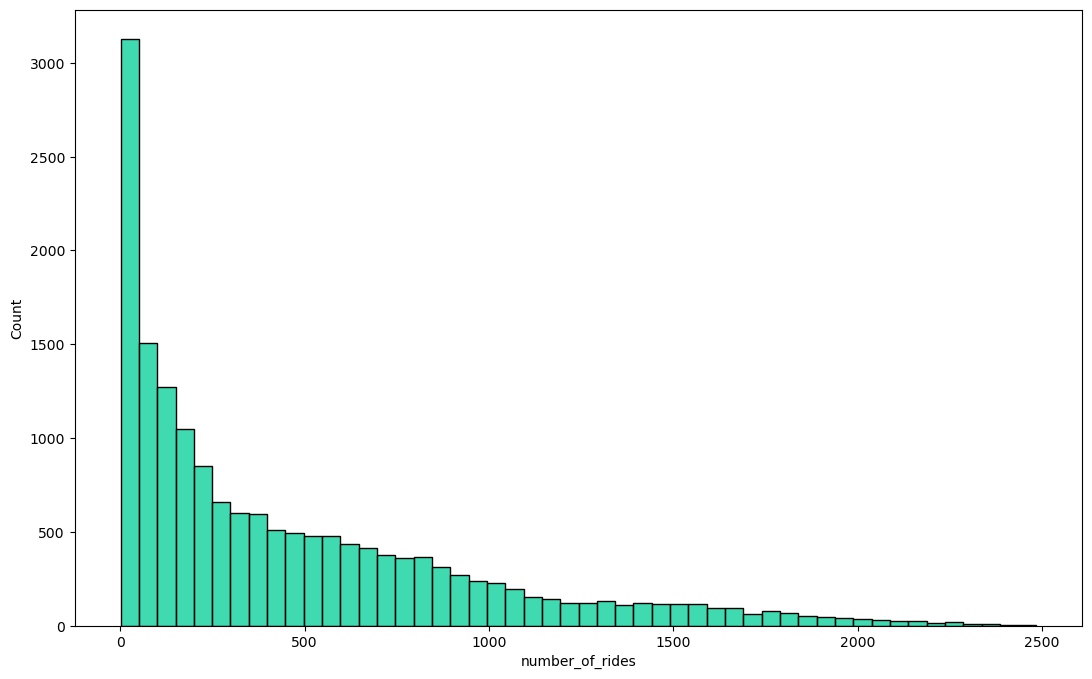

In [5]:
fig, axs = plt.subplots(figsize=(13, 8), ncols=1)
sns.histplot(df["number_of_rides"], bins=50, color="#00ce96")

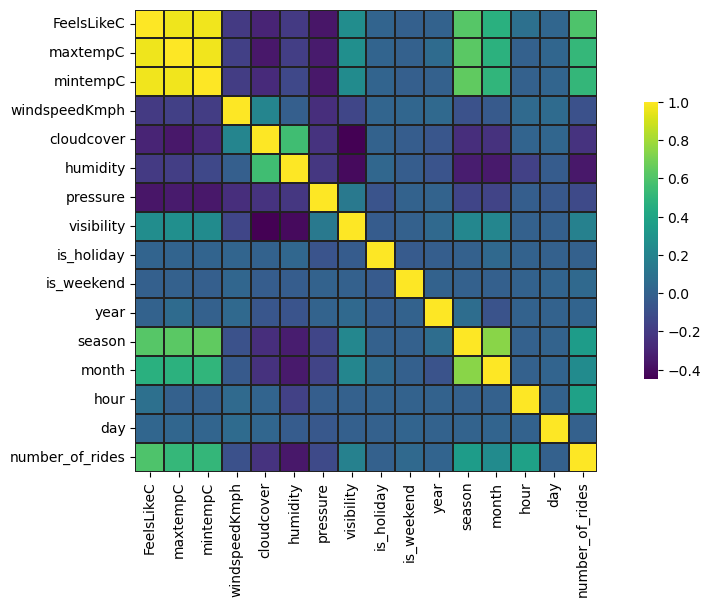

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.heatmap(df.corr(), cmap="viridis",  # Choose a squential colormap
                 annot_kws={'fontsize': 11},  # Reduce size of label to fit
                 fmt='',          # Interpret labels as strings
                 cbar_kws={"shrink": 0.6},
                 square=True,     # Force square cells
                 linewidth=0.01,  # Add gridlines
                 linecolor="#222")

plt.savefig("../imgs/heatmap_features.png", transparent=True)
plt.show()

**Humidity** and the **cloudcover** has very high correlation within themselves, so it is better to drop one to remove any sort of multicollinearity.

**maxtempC**, **mintempC**, the **feeling temperature** and **season** has very high correlation within themselves, so it is better to leave only 1 column to remove any sort of multicollinearity.

In [7]:
df.drop(['maxtempC', 'mintempC', 'season'], inplace=True, axis=1)

In [8]:
# converting to categorical
df['is_holiday'] = df['is_holiday'].astype('category')
df['is_weekend'] = df['is_weekend'].astype('category')
df['year'] = df['year'].astype('category')
df['month'] = df['month'].astype('category')
df['day'] = df['day'].astype('category')
df['hour'] = df['hour'].astype('category')
weekday_dict = {"Monday": 1,
                "Tuesday": 2,
                "Wednesday": 3,
                "Thursday": 4,
                "Friday": 5,
                "Saturday": 6,
                "Sunday": 7}
df['week_day'] = df['week_day'].apply(lambda x: weekday_dict[x])
df['week_day'] = df['week_day'].astype('category')

# <b><span style='color:#4797ef'>|</span> Data processing for training</b>

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.metrics import r2_score

## Train-test Split

In [10]:
df_train, df_test = train_test_split(df.drop("date", axis=1), test_size=.2, random_state=1)

In [11]:
y_train, y_test = df_train['number_of_rides'], df_test['number_of_rides']
for df_ in [df_train, df_test]:
    del df_['number_of_rides'] 
y = y_train.append(y_test, ignore_index = True)

C:\Users\hugom\AppData\Local\Temp\ipykernel_3540\2492945053.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y = y_train.append(y_test, ignore_index = True)


## One-hot encoding

In [12]:
# Creating dummy variables for the categorical features(One Hot Encoding)
train_dict = df_train.to_dict(orient='records')
test_dict = df_test.to_dict(orient='records')

In [13]:
# sparse - is a matrix that is comprised of mostly zero values.
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

DictVectorizer(sparse=False)

In [14]:
X_train = dv.transform(train_dict)
X_test = dv.transform(test_dict)
X = np.concatenate((X_train, X_test))

In [15]:
dv.get_feature_names()

C:\Users\hugom\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['FeelsLikeC',
 'cloudcover',
 'day',
 'hour',
 'humidity',
 'is_holiday',
 'is_weekend',
 'month',
 'pressure',
 'visibility',
 'week_day',
 'windspeedKmph',
 'year']

## Feature Scaling

In [16]:
min_max = MinMaxScaler()
min_max.fit(X_train)

MinMaxScaler()

In [17]:
X_train_scaled = min_max.transform(X_train)
X_test_scaled = min_max.transform(X_test)
X_scaled = np.concatenate((X_train_scaled, X_test_scaled))

## Dimensionality Reduction PCA 

In [18]:
pca = PCA(random_state=1)

pca.fit(X_train_scaled)

PCA(random_state=1)

In [19]:
var_cumulative = np.cumsum(pca.explained_variance_ratio_)

C:\Users\hugom\AppData\Local\Temp\ipykernel_3540\714522965.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(var_cumulative,


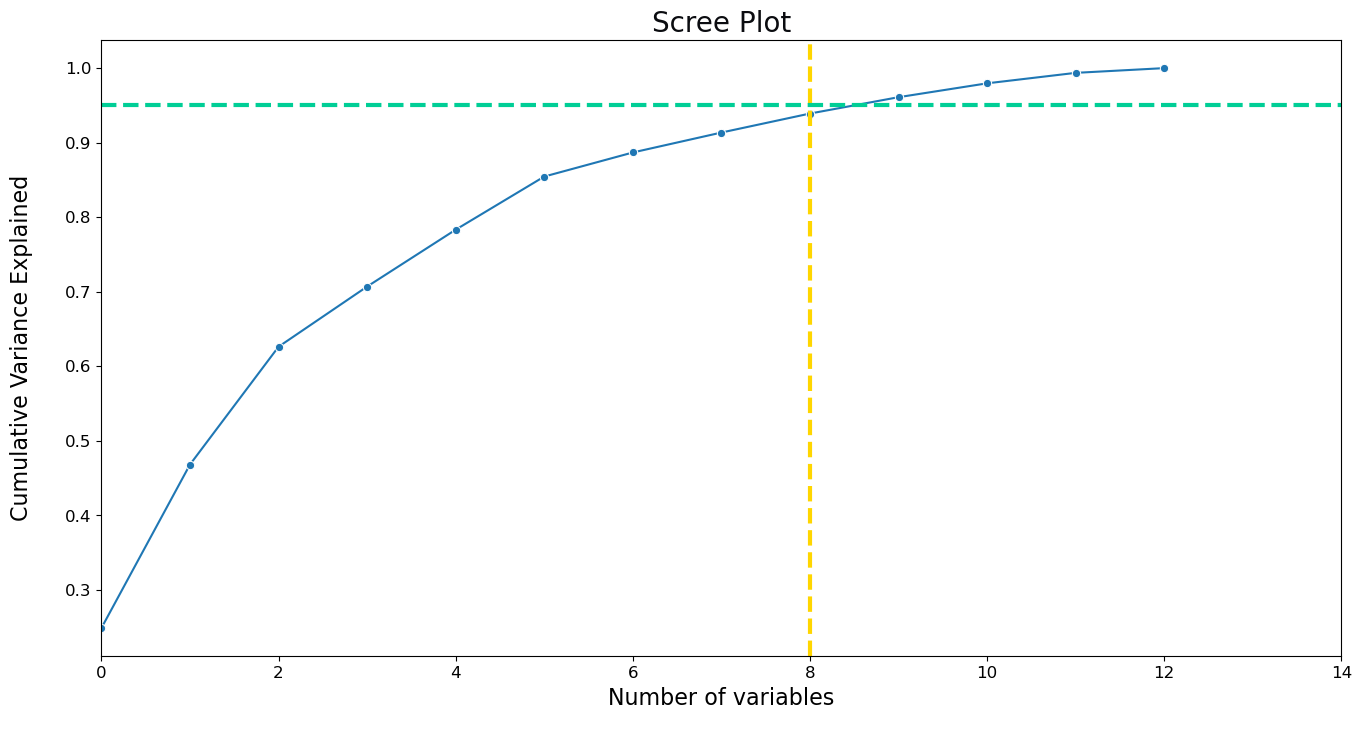

In [20]:
plt.figure(figsize=[16,8])

sns.lineplot(var_cumulative,
             marker='o',
             palette=["#00ce96", "#2a709a"])
plt.axvline(8, color="#ffd600", linestyle='--', linewidth='3')
plt.axhline(0.95, color="#00ce96", linestyle='--', linewidth='3')

plt.title("Scree Plot", size=20, color="#0b0c10")
plt.xlabel("Number of variables\n", size=16)
plt.ylabel("Cumulative Variance Explained\n", size=16)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlim(0, 14)

plt.savefig("../imgs/pca_plot.png", transparent=True)
plt.show()

From the Scree Plot we are able to see that almost 95% of the variance is being explained by 11 variables. Therefore, we are going to use IncrementalPCA from Scikit Learn now to transform only 8 variables.

In [21]:
pca_final = IncrementalPCA(n_components=11) # Specifying the n_components to 17 as per Scree Plot

df_pca = pca_final.fit_transform(X_scaled) # Always fit_transform() on train data

df_train_pca = pca_final.fit_transform(X_train_scaled) # Always fit_transform() on train data

df_test_pca = pca_final.transform(X_test_scaled)# Always transform() on test data

# <b><span style='color:#4797ef'>|</span> Modelling</b>

## Performance tuning (hyperparameters) Bagging+Boosting

In [22]:
from sklearn.model_selection import RandomizedSearchCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import KFold

from sklearn.metrics import (
    r2_score, mean_absolute_error, mean_squared_error)

In [23]:
dt_reg = DecisionTreeRegressor()
rf_reg = RandomForestRegressor()
etr_reg = ExtraTreesRegressor()
xgb_reg = XGBRegressor()

In [24]:
def evaluate_models(X):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = dict()

    for reg in [dt_reg, rf_reg, etr_reg, xgb_reg]:
        reg_list = []
        for train_idxs, test_idxs in kfold.split(X):
            X_train, X_test = X[train_idxs], X[test_idxs]
            y_train, y_test = y[train_idxs], y[test_idxs]

            reg.fit(X_train, y_train)
            y_pred = reg.predict(X_test)
            reg_list.append(r2_score(y_test, y_pred))
        scores[reg.__class__.__name__] = reg_list
    for key in scores.keys():
        print(f'{key}' + ' ' +
              f'{np.mean(scores[key]):.3f} +- {np.std(scores[key]):.3f}')

In [25]:
# simple X
evaluate_models(X)

DecisionTreeRegressor 0.887 +- 0.008
RandomForestRegressor 0.943 +- 0.005
ExtraTreesRegressor 0.953 +- 0.004
XGBRegressor 0.958 +- 0.003


In [26]:
# scaled X
evaluate_models(X_scaled)

DecisionTreeRegressor 0.884 +- 0.008
RandomForestRegressor 0.944 +- 0.005
ExtraTreesRegressor 0.953 +- 0.003
XGBRegressor 0.958 +- 0.003


In [27]:
# scaled and redundant X
evaluate_models(df_pca)

DecisionTreeRegressor 0.723 +- 0.017
RandomForestRegressor 0.882 +- 0.004
ExtraTreesRegressor 0.910 +- 0.004
XGBRegressor 0.861 +- 0.007


R2 became smaller after applying PCA, let's stop at the scaling step.  
Let's choose **XGBRegressor** as our model

In [28]:
n_estimators = [int(x) for x in np.linspace(100, 1000, 10)]

max_depth = [int(x) for x in np.linspace(6, 30, 5)]

learning_rate = [x for x in np.arange(0.001, 0.4, 0.001)]

# how many observations we need to have in a leaf node
min_child_weight = list(range(1, 10))

xg_grid = dict(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate,
               min_child_weight=min_child_weight)
print(xg_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_depth': [6, 12, 18, 24, 30], 'learning_rate': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.010000000000000002, 0.011, 0.012, 0.013000000000000001, 0.014000000000000002, 0.015, 0.016, 0.017, 0.018000000000000002, 0.019000000000000003, 0.02, 0.021, 0.022000000000000002, 0.023, 0.024, 0.025, 0.026000000000000002, 0.027000000000000003, 0.028, 0.029, 0.030000000000000002, 0.031, 0.032, 0.033, 0.034, 0.035, 0.036000000000000004, 0.037000000000000005, 0.038, 0.039, 0.04, 0.041, 0.042, 0.043000000000000003, 0.044000000000000004, 0.045, 0.046, 0.047, 0.048, 0.049, 0.05, 0.051000000000000004, 0.052000000000000005, 0.053000000000000005, 0.054, 0.055, 0.056, 0.057, 0.058, 0.059000000000000004, 0.060000000000000005, 0.061, 0.062, 0.063, 0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07, 0.07100000000000001, 0.07200000000000001, 0.07300000000000001, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.

In [29]:
xgb_random = RandomizedSearchCV(xgb_reg, param_distributions=xg_grid, cv=5,
                                n_iter=20, random_state=1, scoring="r2", n_jobs=-1, verbose=1)
xgb_random.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          callbacks=None, colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=0, gpu_id=-1,
                                          grow_policy='depthwise',
                                          importance_type=None,
                                          interaction_constraints='',
                                          learning_rate=0.3000...
                                                          0.015, 0.016, 0.017,
                                                          0.0180000000

In [30]:
y_pred_xgb = xgb_random.predict(X_test_scaled)

In [31]:
print("R2 score: ",xgb_random.best_score_)
print("best_params: \n",xgb_random.best_params_)

R2 score:  0.9633428072681408
best_params: 
 {'n_estimators': 900, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.23}


## Time series forecasting using LSTM

In [32]:
from tqdm import tqdm_notebook as tqdm
from keras.preprocessing import sequence

from keras.models import Sequential
from tensorflow.keras import regularizers
from keras.layers import Dense, Dropout , LSTM , Bidirectional 

In [33]:
prediction_days = 90

In [34]:
df_train = df[:-prediction_days]
df_test = df[-prediction_days:]
# .drop(columns='number_of_rides'
print(df.shape, df_train.shape, df_test.shape)

(16749, 15) (16659, 15) (90, 15)


In [35]:
scaler = MinMaxScaler(feature_range=(0, 1))

scaled_target = scaler.fit_transform(
    df['number_of_rides'].values.reshape(-1, 1))

In [36]:
train_target = scaled_target[:-prediction_days]
test_target = scaled_target[-prediction_days:]

print(scaled_target.shape, train_target.shape, test_target.shape)

(16749, 1) (16659, 1) (90, 1)


In [37]:
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in tqdm(range(prediction_days, len(train_target))):
    x_train.append(train_target[i-prediction_days:i, 0])
    y_train.append(train_target[i, 0])

# Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

C:\Users\hugom\AppData\Local\Temp\ipykernel_3540\432406926.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(prediction_days, len(train_target))):


  0%|          | 0/16569 [00:00<?, ?it/s]

After scaling all the values in the data set between 0 and 1, I specify the number of days to predict. After this value, I separate the data as x_train and y_train. With the value of 90 we have given, the model will work in such a way that it examines 90 data and predicts the next one, then examines 90 data again and tries to predict the next one.

In [38]:
model_inputs = scaled_target[len(scaled_target)-len(test_target)-prediction_days:]

# Create the x_test and y_test data sets
x_test = []

for x in  tqdm(range(prediction_days, len(model_inputs))):
    x_test.append(model_inputs[x-prediction_days:x, 0])

# Convert x_test to numpy array
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

C:\Users\hugom\AppData\Local\Temp\ipykernel_3540\1365628269.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for x in  tqdm(range(prediction_days, len(model_inputs))):


  0%|          | 0/90 [00:00<?, ?it/s]

**Guide to build LSTM model**
1. Reduce the number of units in your LSTM. Start from there. Reach a point where your model stops overfitting.

2. Then, add dropout if required.

3. After that, the next step is to add the tf.keras.Bidirectional. If still, you are not satfisfied then, increase number of layers. Remember to keep return_sequences True for every LSTM layer except the last one.

It is seldom I come across networks using layer regularization despite the availability because dropout and layer regularization have a same effect and people usually go with dropout (at maximum, I have seen 0.3 being used).

In [39]:
model = Sequential()

model.add(LSTM(units=128, activation='relu', return_sequences=True, input_shape = (x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=128, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=128, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1)) # Prediction of the next value

In [40]:
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(x_train, y_train, epochs=5,
                    batch_size=32, validation_split=0.1)

Epoch 1/5
466/466 [==============================] - 77s 160ms/step - loss: 0.0279 - val_loss: 0.0183
Epoch 2/5
466/466 [==============================] - 74s 159ms/step - loss: 0.0201 - val_loss: 0.0177
Epoch 3/5
466/466 [==============================] - 74s 160ms/step - loss: 0.0194 - val_loss: 0.0175
Epoch 4/5
466/466 [==============================] - 74s 160ms/step - loss: 0.0189 - val_loss: 0.0171
Epoch 5/5
466/466 [==============================] - 74s 159ms/step - loss: 0.0185 - val_loss: 0.0160


In this step, we set up our model, since it is a basic neural network, we set up a Sequential model directly. Here, after choosing LSTM layers, I applied Dropout to increase efficiency and eliminate useless nodes, so that after each LSTM layer, I didn’t move with the worst-performing nodes to the next step. Here I have eliminated 20% of the total number of nodes.

Attention here!!! We have to give the input_shape value to our first LSTM layer, because our model does not know the size of the data it will process, we do not need to enter this value in the next steps. In the last step, I returned a single value with the Dense layer, so this estimated value will be the average temperature predicted by our model.

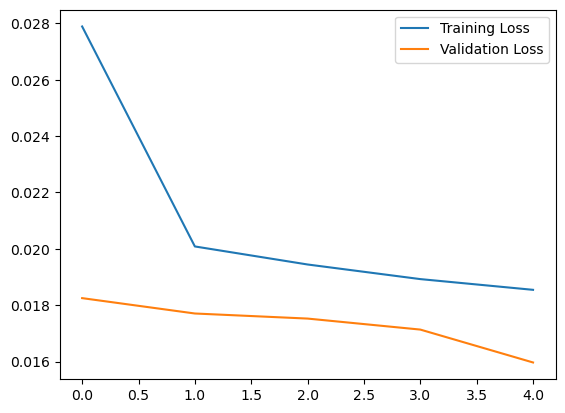

In [41]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.show()

In [42]:
# Make Predictions on Test Data
y_pred = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred)

3/3 [==============================] - 1s 48ms/step


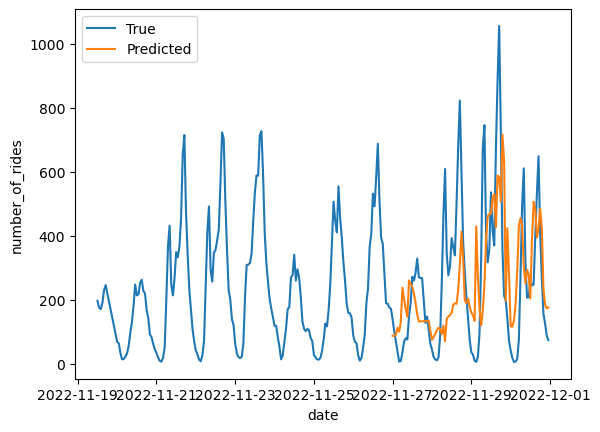

In [43]:
### Visualization ###
#####################
pred_ = pd.DataFrame(df_test['date'])
pred_['number_of_rides'] = y_pred
pred_['date'] = pd.to_datetime(pred_['date'])

original = df[-270:]

sns.lineplot(x=original['date'], y=original['number_of_rides'], label="True")
sns.lineplot(x=pred_['date'], y=pred_['number_of_rides'], label="Predicted")
plt.show()

# <b><span style='color:#4797ef'>|</span> Make html</b>

In [45]:
!jupyter nbconvert --to html "modelling+tuning.ipynb"

[NbConvertApp] Converting notebook modelling+tuning.ipynb to html
[NbConvertApp] Writing 835997 bytes to modelling+tuning.html
